In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Import personal functions
import sys
#sys.path.append("C:/Users/Olivi/OneDrive - TU Eindhoven/Soft robotic matter/GitHub/Thermal_Soft_Robotics/Functions")
sys.path.append("//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Functions")
import FluidicSetupFunctions
from save_plot_func import save_plot

# Set figure style
import scienceplots
plt.style.use(['science','nature','no-latex','vibrant'])

# Specific 
from scipy.integrate import odeint

In [101]:
#Location = r"C:\Users\Olivi\OneDrive - TU Eindhoven\Soft robotic matter\data_analysis"
Location = r"//sun/overvelde/group-folder/PROJECTS/Thermal_soft_robotics_Olivier/Git/Thermal_Soft_Robotics/Thermal_actuation/Experimental/Fluidic/Pressure_flow_plastic_bottle"
Foldernames = ["/Data"]

data = FluidicSetupFunctions.LoadData(Foldernames = Foldernames,Location=Location)

print(data[0][-1].head)

Loading... Folder 1 of 1, Sample 1 of 7
Loading... Folder 1 of 1, Sample 2 of 7
Loading... Folder 1 of 1, Sample 3 of 7
Loading... Folder 1 of 1, Sample 4 of 7
Loading... Folder 1 of 1, Sample 5 of 7
Loading... Folder 1 of 1, Sample 6 of 7
Loading... Folder 1 of 1, Sample 7 of 7
<bound method NDFrame.head of        presFesto-0  AWM20-12  SSCDP05-3    Time
0         0.000387 -0.002912 -15.255849   0.001
1         0.000155 -0.001955 -14.905454   0.002
2        -0.000019 -0.001086 -14.891623   0.003
3        -0.000140 -0.000304 -15.169332   0.004
4        -0.000213  0.000392 -15.693559   0.005
...            ...       ...        ...     ...
19595     0.072877  0.066065   3.291364  19.596
19596     0.072835  0.066664   0.243335  19.597
19597     0.072798  0.067566  -4.106382  19.598
19598     0.072769  0.068807  -9.915566  19.599
19599     0.072749  0.070422 -17.341999  19.600

[19600 rows x 4 columns]>


Text(0.5, 0, 'Time [$s$]')

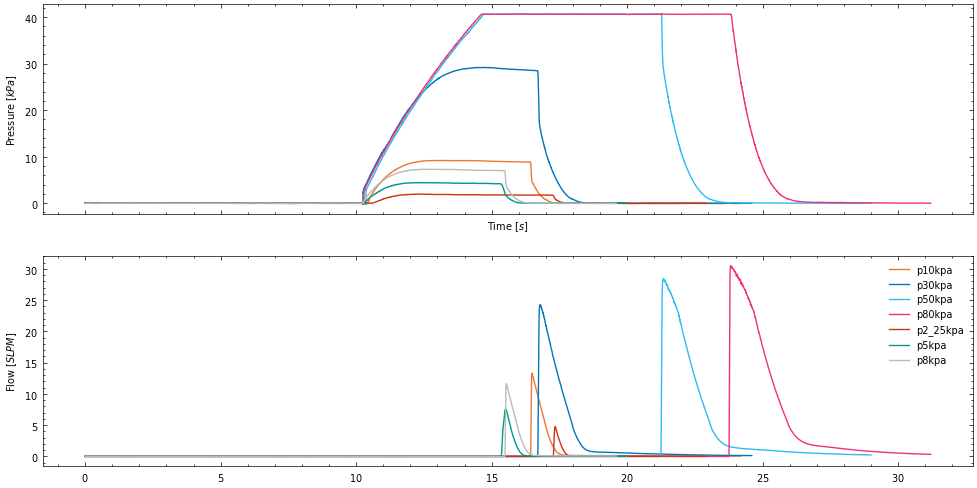

In [102]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12,6))
data[0][0]['SSCDP05-3']
for i in range(len(data[0])):
    ax1.plot(data[0][i]['Time'],data[0][i]['SSCDP05-3']/1000,label=data[1]['Samplename'][i])
    ax2.plot(data[0][i]['Time'],data[0][i]['AWM20-12'],label=data[1]['Samplename'][i])
plt.legend()
ax1.set_ylabel('Pressure [$kPa$]')
ax2.set_ylabel('Flow [$SLPM$]')
ax1.set_xlabel('Time [$s$]')

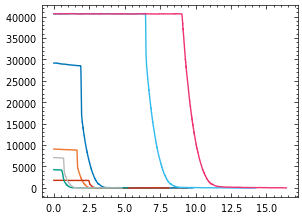

In [103]:
for i in range(len(data[0])):
    cutoff = 14.8
    sample_rate = data[1]['Samplerate'][i]
    
    # Find index to cutoff
    index_cutoff = int(cutoff * sample_rate)
    
    # Get new zero value for Time column
    new_zero = data[0][i].iloc[index_cutoff]['Time']
    
    # Subtract new_zero from all values in Time column
    data[0][i]['Time'] = data[0][i]['Time'] - new_zero
    
    # Keep rows after cutoff
    data[0][i] = data[0][i].iloc[index_cutoff:]
    
    # Reset index
    data[0][i].reset_index(drop=True, inplace=True)

    plt.plot(data[0][i]['Time'],data[0][i]['SSCDP05-3'],label=data[1]['Samplename'][i])

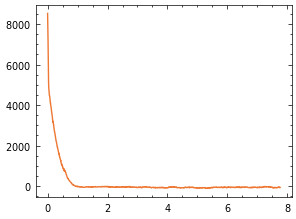

In [104]:
treshold=70
difference=np.diff(data[0][0]['SSCDP05-3'])

indices = np.where(difference < -treshold)

sharp_decrease= data[0][0]['SSCDP05-3'][indices[0]]
plt.plot(data[0][0]['Time'][:-indices[0][0]],data[0][0]['SSCDP05-3'][indices[0][0]:])

2169
2204
6983
9119
2584
930
1166


Text(0.5, 0, 'Time [$s$]')

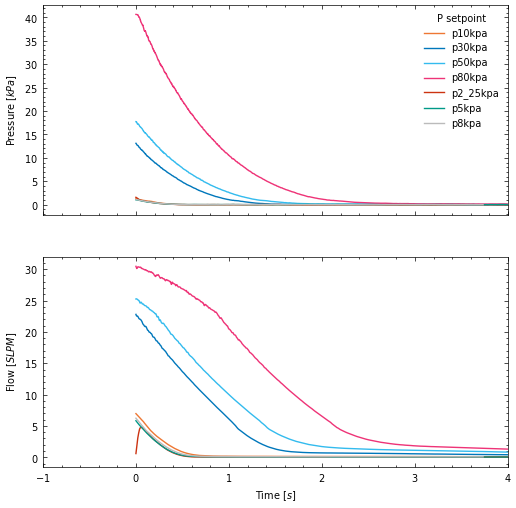

In [115]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True,figsize=(6,6))
indices = [] 
for i in range(len(data[0])):
    treshold=100
    difference=np.diff(data[0][i]['SSCDP05-3'])
    indices.append(np.argmax(difference)) 
    print(indices[-1])

    ax1.plot(data[0][i]['Time'][:-(indices[i]-100)],data[0][i]['SSCDP05-3'][(indices[i]-100):]/1000,label=data[1]['Samplename'][i])
    ax2.plot(data[0][i]['Time'][:-(indices[i]-100)],data[0][i]['AWM20-12'][(indices[i]-100):],label=data[1]['Samplename'][i])
    #plt.plot(data[0][i]['Time'],data[0][i]['SSCDP05-3'],label = data[1]['Samplename'][i])

ax2.set_ylabel('Flow [$SLPM$]')
ax1.set_ylabel('Pressure [$kPa$]')
plt.xlim(-1,4)
ax1.legend(title='P setpoint')
ax2.set_xlabel('Time [$s$]')

In [106]:
data[1]['Samplename']

['p10kpa', 'p30kpa', 'p50kpa', 'p80kpa', 'p2_25kpa', 'p5kpa', 'p8kpa']

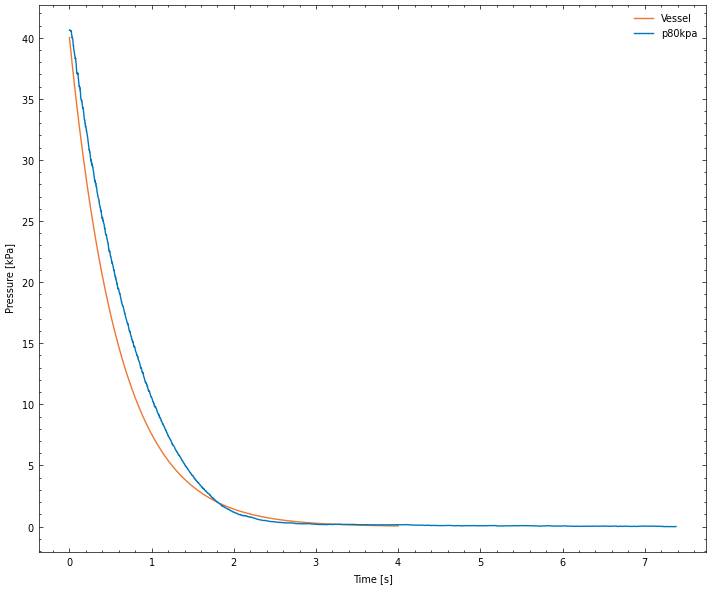

In [107]:
P_tank_0 = 1.40e5  # Initial pressure in first tank, Pa
P_amb = 1e5  # Ambient pressure, Pa
V_tank = 0.0015  # Volume of first tank, m^3
R_valve = 400# Resistance of second valve, Pa.s/m^3

# System of ODEs
def dPdt(P, t):
    P_tank= P[0]

    # Flow and pressure from tank to amb      
    Q_tank_to_amb = (P_tank - P_amb) / R_valve
    dP_tank_dt = -Q_tank_to_amb / V_tank

    return [dP_tank_dt]

# Time array for simulation
t = np.linspace(0, 4,1000 ) 

# Solve system of ODEs
P_tank = odeint(dPdt, [P_tank_0], t)

# Calculate flow rates Q1 and Q2

plt.figure(figsize=(14, 6))

plt.subplot(121)  # The first plot in a 1-row, 2-column configuration
plt.plot(t, (P_tank-P_amb )/ 1e3, label='Vessel')  # Pressure in first tank, bar
plt.plot(data[0][3]['Time'][:-(indices[3]-100)],data[0][3]['SSCDP05-3'][(indices[3]-100):]/1000,label=data[1]['Samplename'][3])
    
#plt.axhline(P_amb/1e3,label='$P_{amb}$',color='green')
plt.xlabel('Time [s]')
#plt.ylim(0, 2)
#plt.xlim(0,1)
plt.ylabel('Pressure [kPa]')
plt.legend()

plt.tight_layout()
plt.show()

In [108]:
data[1]

{'Samplerate': [1000, 1000, 1000, 1000, 1000, 1000, 1000],
 'Samplename': ['p10kpa',
  'p30kpa',
  'p50kpa',
  'p80kpa',
  'p2_25kpa',
  'p5kpa',
  'p8kpa'],
 'Offset': [{'presFesto-0': 5.040482444444444,
   'AWM20-12': 1.0205983333333335,
   'SSCDP05-3': 2.5123115555555557},
  {'presFesto-0': 5.0394526666666675,
   'AWM20-12': 1.020833777777778,
   'SSCDP05-3': 2.509509},
  {'presFesto-0': 5.040506777777778,
   'AWM20-12': 1.0207154444444446,
   'SSCDP05-3': 2.5090715555555554},
  {'presFesto-0': 5.039768222222222,
   'AWM20-12': 1.0207822222222223,
   'SSCDP05-3': 2.5083496666666667},
  {'presFesto-0': 5.0387960000000005,
   'AWM20-12': 1.0211664444444446,
   'SSCDP05-3': 2.5086287777777776},
  {'presFesto-0': 5.038554777777778,
   'AWM20-12': 1.020697888888889,
   'SSCDP05-3': 2.5076973333333337},
  {'presFesto-0': 5.038341555555555,
   'AWM20-12': 1.0204916666666666,
   'SSCDP05-3': 2.509126333333333}]}

R^2: 0.99


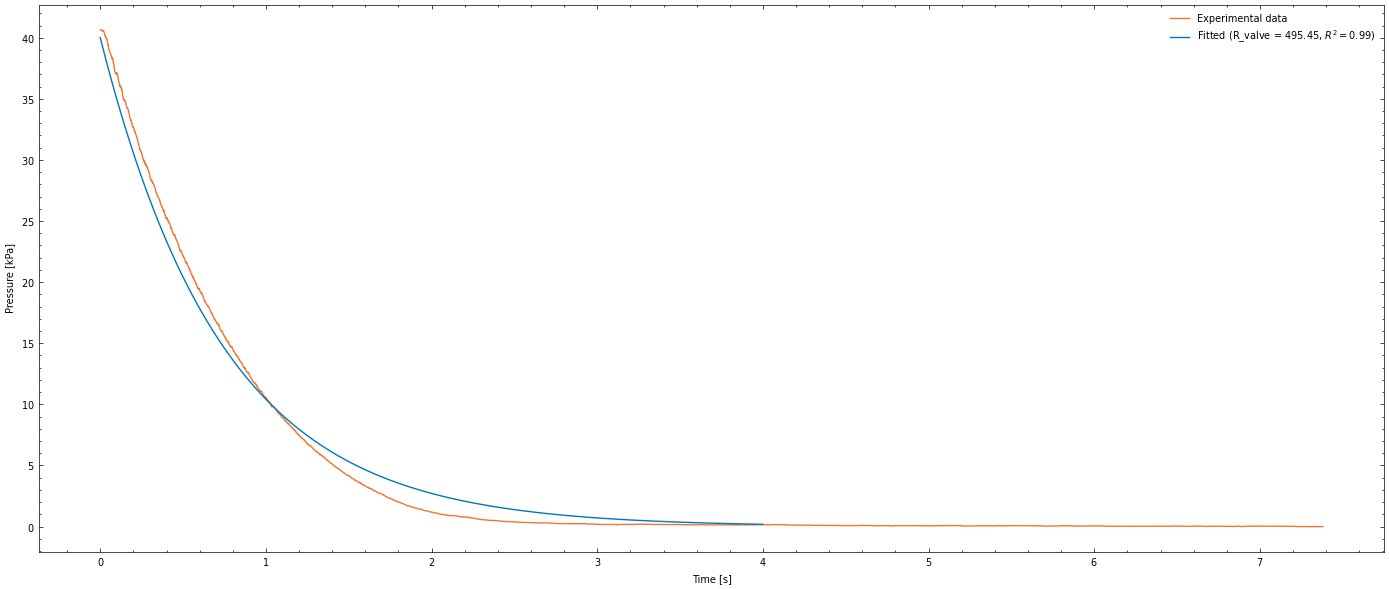

In [109]:
from scipy.optimize import curve_fit

# Define the original ODE equation
def original_dPdt(P, t, R_valve):
    P_tank = P[0]
    Q_tank_to_amb = (P_tank - P_amb) / R_valve
    dP_tank_dt = -Q_tank_to_amb / V_tank
    return [dP_tank_dt]

# Define function for fitting
def fit_func(t, R_valve):
    P_tank_fit = odeint(original_dPdt, [P_tank_0], t, args=(R_valve,))
    return (P_tank_fit[:, 0] - P_amb) / 1e3

# Data for fitting
t_data = data[0][3]['Time'][:-(indices[3]-100)]
P_data = data[0][3]['SSCDP05-3'][(indices[3]-100):] / 1000

# Initial guess for R_valve
initial_guess = [R_valve]

# Perform curve fitting
params, params_covariance = curve_fit(fit_func, t_data, P_data, p0=initial_guess)

# Extract fitted parameters
R_valve_fit = params[0]

# Calculate fitted values
y_fit = fit_func(t_data, R_valve_fit)

# Calculate mean observed values
y_mean = np.mean(P_data)

# Calculate sum of squares of residuals
ss_res = np.sum((P_data - y_fit)**2)

# Calculate total sum of squares
ss_tot = np.sum((P_data - y_mean)**2)

# Calculate R^2
r2 = 1 - (ss_res / ss_tot)

print('R^2: {:.2f}'.format(r2))

# Calculate the "Vessel" line using the original ODE equation and initial R_valve value
P_tank_vessel = odeint(original_dPdt, [P_tank_0], t, args=(R_valve,))

# Plot the results
plt.figure(figsize=(14, 6))
#plt.plot(t, (P_tank_vessel[:, 0] - P_amb) / 1e3, label='Vessel (R_valve = {})'.format(R_valve))
plt.plot(t_data, P_data, label='Experimental data')
plt.plot(t, (odeint(original_dPdt, [P_tank_0], t, args=(R_valve_fit,))[:, 0] - P_amb) / 1e3,
         label='Fitted (R_valve = {:.2f}, $R^2 = {:.2f}$)'.format(R_valve_fit, r2))
plt.xlabel('Time [s]')
plt.ylabel('Pressure [kPa]')
plt.legend()
plt.tight_layout()
plt.show()


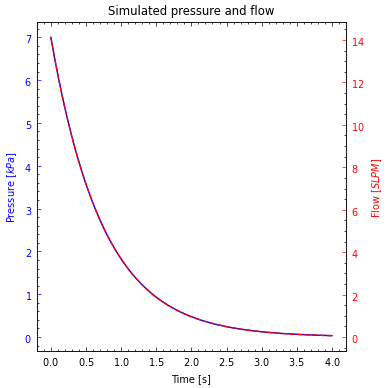

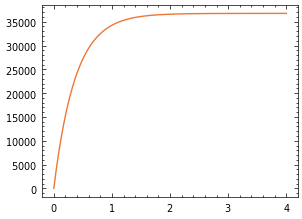

In [119]:
P_tank_0 = 1.07e5  # Initial pressure in first tank, Pa
P_amb = 1e5  # Ambient pressure, Pa
V_tank = 0.0015  # Volume of first tank, m^3
R_valve = R_valve_fit# Resistance of second valve, Pa.s/m^3
P_rel_0 = 0
Q_0 = 0 

# System of ODEs
def dPdt(P, t, R_valve, V_tank, P_amb):
    P_tank, P_rel = P

    # Flow and pressure from tank to amb      
    Q_tank_to_amb = (P_tank - P_amb) / R_valve
    dP_tank_dt = -Q_tank_to_amb / V_tank
    dP_rel_dt = (P_tank - P_amb) * Q_tank_to_amb

    return [dP_tank_dt, dP_rel_dt]

# Solve system of ODEs
P, P_rel = odeint(dPdt, [P_tank_0, P_rel_0], t, args=(R_valve, V_tank, P_amb)).T

# Calculate the flow rate from the pressure values
Q = (P - P_amb) / R_valve


# Calculate flow rates Q1 and Q2

fig, ax1 = plt.subplots(figsize=(4, 4))

color='blue'
ax1.set_ylabel('Pressure [$kPa$]',color=color)
ax1.set_xlabel('Time [s]')
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(t, (P-P_amb )/ 1e3, label='Pressure',color=color)  # Pressure in first tank, bar
ax1.tick_params(axis='y', color=color)

ax2=ax1.twinx()
color='red'
ax2.set_ylabel('Flow [$SLPM$]',color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.plot(t, Q, label='Flow',linestyle='--',color=color) 
ax2.tick_params(axis='y', color=color)




#plt.legend()
plt.title('Simulated pressure and flow')
plt.tight_layout()
plt.show()

plt.plot(t,P_rel)


In [118]:
gamma=1.4
U_start = V_tank*P[0]/(gamma-1)
U_end = V_tank*P[-1]/(gamma-1)
print(U_start-U_end)

26.129323197430267
